# Проект "риск инфаркта"

## Загрузка требуемых библиотек

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import joblib

from scipy.stats import mannwhitneyu

from sklearn.model_selection import (
    RandomizedSearchCV,
    ParameterGrid,
    train_test_split
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Загрузка данных

In [2]:
# тестовый датасет
test_data_path = os.path.join('data', 'heart_test.csv')
test_data = pd.read_csv(test_data_path)
print(test_data.head(3))

   Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.494382     0.264286    0.062328       0.0             1.0   
1           1  0.224719     0.953571    0.082493       1.0             0.0   
2           2  0.629213     0.092857    0.064161       0.0             1.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.361618  ...   
1      0.0      1.0                  0.0                 0.996483  ...   
2      1.0      1.0                  0.0                 0.995561  ...   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0       0.306494                              1.0             0.333333   
1       0.087013                              0.0             0.166667   
2       0.205195                              7.0             1.000000   

   Blood sugar     CK-MB  Troponin  Gender  Systolic blood pressure  \
0     0.227018  0.0482

In [3]:
# тренировочный датасет
train_data_path = os.path.join('data', 'heart_train.csv')
train_data = pd.read_csv(train_data_path)
print(train_data.head(3))

   Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.535505  ...   
1      0.0      0.0                  1.0                 0.068690  ...   
2      1.0      1.0                  1.0                 0.944001  ...   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1    

## Предобработка данных

### Обработка train data

In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

В данных имеются пропущенные значения.

In [5]:
# сформируем таблицу с анализом пропущенных значений по признакам
missing_info = {
    'feature': [],
    'num_NA': [],
    'frac_NA_perc': []
}

total_rows = train_data.shape[0]

for col in train_data.columns:
    num_na = train_data[col].isna().sum()
    missing_info['feature'].append(col)
    missing_info['num_NA'].append(num_na)
    missing_info['frac_NA_perc'].append(round(num_na / total_rows * 100, 2))

missing_df = pd.DataFrame(missing_info)
missing_df = missing_df.loc[missing_df['num_NA'] != 0]
print(missing_df)

                            feature  num_NA  frac_NA_perc
4                          Diabetes     243           2.8
5                    Family History     243           2.8
6                           Smoking     243           2.8
7                           Obesity     243           2.8
8               Alcohol Consumption     243           2.8
11          Previous Heart Problems     243           2.8
12                   Medication Use     243           2.8
13                     Stress Level     243           2.8
18  Physical Activity Days Per Week     243           2.8


**Вывод:**
* имеются пропущенные значения, причем из количество по признакам совпадает и составляет 2.8% от мощности признака (целесообразно произвести замену);
* неккоретные заголовки (необходимо перевести в 'snake_case');
* 'id' необходимо перенести в индекс;
* признак 'gender' - категориальный бинарный (необходимо закодировать);
* часть признаков - категориальные;
* все признаки кроме 'gender' - количественные (int, float);
* 'Unnamed: 0' - лишний столбец.

In [6]:
# удаляем признак 'Unnamed: 0'
train_data = train_data.drop('Unnamed: 0', axis=1)

# переносим 'id' в индекс
train_data = train_data.set_index('id', drop=True)

# переименуем столбцы в 'snake_case'
def to_snake_type(string):
    return ['_'.join(w.lower().replace('-', '').split()) for w in string]
train_data.columns = to_snake_type(train_data.columns)

# осуществим замену бинарного категориального признака 'gender' на "1 / 0"
train_data['gender'] = train_data['gender'].map({'Male': 1, 'Female': 0, '1.0':1, '0.0': 0})

# переименуем название таргета
train_data.rename(columns={'heart_attack_risk_(binary)': 'heart_attack_risk'}, inplace=True)

Рассмотрим признаки с точки зрения ключевых статистик и уникальных значений.

In [7]:
# ключевые статистики
display(train_data.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,8685.0,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
cholesterol,8685.0,0.501070,0.284716,0.0,0.267857,0.499780,0.746429,1.0
heart_rate,8685.0,0.050658,0.023453,0.0,0.034830,0.050412,0.065995,1.0
diabetes,8442.0,0.652097,0.476333,0.0,0.000000,1.000000,1.000000,1.0
family_history,8442.0,0.489576,0.499921,0.0,0.000000,0.000000,1.000000,1.0
smoking,8442.0,0.902867,0.296157,0.0,1.000000,1.000000,1.000000,1.0
obesity,8442.0,0.498342,0.500027,0.0,0.000000,0.000000,1.000000,1.0
alcohol_consumption,8442.0,0.601990,0.489517,0.0,0.000000,1.000000,1.000000,1.0
exercise_hours_per_week,8685.0,0.503378,0.284810,0.0,0.263286,0.502110,0.748709,1.0
diet,8685.0,1.057455,0.866645,0.0,0.000000,1.000000,2.000000,3.0


In [8]:
# анализ уникальных значений признаков
train_data_info = {
    'name': [],
    'nunique': [],
    'unique_value': []
}

for col in train_data.columns:
    train_data_info['name'].append(col)
    train_data_info['nunique'].append(train_data[col].nunique())
    train_data_info['unique_value'].append(train_data[col].unique())

train_data_info = pd.DataFrame(train_data_info).sort_values(by='nunique', ascending=False)
train_data_info

,name,nunique,unique_value
13,sedentary_hours_per_day,7933,"[0.2257038936087668, 0.2899234347765663, 0.550..."
8,exercise_hours_per_week,7933,"[0.5355049297181428, 0.068689995709055, 0.9440..."
15,bmi,7933,"[0.4591759037537125, 0.1170530662087463, 0.373..."
14,income,7808,"[0.105948008517571, 0.1642169122375773, 0.5987..."
16,triglycerides,772,"[0.9792207792207792, 0.5155844155844156, 0.012..."
21,ckmb,679,"[0.0482287853675997, 0.0176155152680034, 0.008..."
22,troponin,340,"[0.0365123661820742, 0.0001941936110301, 0.000..."
1,cholesterol,282,"[0.732142857142857, 0.325, 0.8607142857142855,..."
20,blood_sugar,239,"[0.2270175751137986, 0.150197628458498, 0.2312..."
24,systolic_blood_pressure,100,"[0.2129032258064515, 0.4129032258064516, 0.238..."


Из таблицы выше можно заметить, что часть признаков являются закодированными категориальными значениями ('nunique < 11).

In [9]:
# составим список категориальных признаков
cat_col = list(train_data_info.loc[train_data_info['nunique'] < 11, 'name'])

Осуществим замену пропущенных значений признаков на "типичные" по группировке признаков в зависимости от значения таргета, при этом для признаков значения которых являются непрерывными значениями будем использовать среднее значение по выборке, а для категориальных признаков будем использовать моду.

In [10]:
missing_cols = [col for col in train_data.columns if train_data[col].isna().sum() > 0]
target_unique = train_data['heart_attack_risk'].unique()

for col in missing_cols:
    for t in target_unique:      
        if col in cat_col:
            na_plug = train_data[train_data['heart_attack_risk'] == t][col].mode()[0]
        else:
            na_plug = train_data[train_data['heart_attack_risk'] == t][col].mean()
        mask = (train_data[col].isna()) & (train_data['heart_attack_risk'] == t)
        train_data.loc[mask, col] = na_plug

In [11]:
# удаляем явные дубликаты
train_data = train_data.drop_duplicates()

### Обработка test data

In [12]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

**Вывод:** выявленные особенности аналогичны датасету 'train_data'

In [13]:
# удаляем признак 'Unnamed: 0'
test_data = test_data.drop('Unnamed: 0', axis=1)

# переносим 'id' в индекс
test_data = test_data.set_index('id', drop=True)

# переименуем столбцы в 'snake_case'
test_data.columns = to_snake_type(test_data.columns)

# осуществим замену бинарного категориального признака 'gender' на "1 / 0"
test_data['gender'] = test_data['gender'].map({'Male': 1, 'Female': 0, '1.0':1, '0.0': 0})

# удалим пропущенные значения (в связи с тем, что отсутствует таргет)
test_data = test_data.dropna()

# удаляем явные дубликаты
test_data = test_data.drop_duplicates()

### Вывод

 * Пропущенные значения по признакам совпадают и составляют 2.8% от мощности признака.
 * Осуществлена замена пропущенных значений в зависимости от значения таргета (для количетсвенных данных - средняя, для категориальных - мода).
 * Переименованы заголовки в 'snake_case'.
 * Признак 'id' перенесен в индекс.
 * Исправлена ошибка в неполной кодировке признака 'gender'.
 * Удален признак 'Unnamed: 0' - лишний столбец.
 * Явные дубликаты отсутствуют.
 * Выявлено 11 категориальных признаков.

## Исследовательский анализ данных

### Количественный анализ

Рассмотрим ключевые статистики признаков в разрезе значения таргета.

In [14]:
print(f"Сравнение средних значений признаков в разрезе таргета:")
analyse = train_data.groupby('heart_attack_risk').agg(['mean']).T
display(analyse)
print()
print(f"Сравнение дисперсии значений признаков в разрезе таргета:")
analyse = train_data.groupby('heart_attack_risk').agg(['std']).T
display(analyse)

Сравнение средних значений признаков в разрезе таргета:


,heart_attack_risk,0.0,1.0
age,mean,0.449175,0.451433
cholesterol,mean,0.497145,0.508461
heart_rate,mean,0.050924,0.050157
diabetes,mean,0.661495,0.662463
family_history,mean,0.467560,0.491537
smoking,mean,0.908145,0.900763
obesity,mean,0.525212,0.488218
alcohol_consumption,mean,0.624118,0.592433
exercise_hours_per_week,mean,0.501409,0.507085
diet,mean,1.085331,1.004978



Сравнение дисперсии значений признаков в разрезе таргета:


,heart_attack_risk,0.0,1.0
age,std,0.229284,0.234723
cholesterol,std,0.281952,0.289751
heart_rate,std,0.025682,0.018537
diabetes,std,0.473243,0.472948
family_history,std,0.498991,0.500011
smoking,std,0.288846,0.299029
obesity,std,0.499408,0.499944
alcohol_consumption,std,0.484392,0.491463
exercise_hours_per_week,std,0.282701,0.288750
diet,std,0.896190,0.805634


Анализ средних значений и стандартных отклонений признаков в разрезе таргета позволяет заметить что средние и вариация признаков измеют незначительные отклонения. Для выявления различий между выборками используем тест Манна-Уитни.

In [15]:
output_df = {
    'feature': [],
    'Mann–Whitney (p-value)': [],
    'p-value < 0.05': []
}

for col in [col for col in train_data.columns if col != 'heart_attack_risk']:
    group0 = train_data[train_data['heart_attack_risk']==0][col]
    group1 = train_data[train_data['heart_attack_risk']==1][col]
    stat, p = mannwhitneyu(group0, group1)
    output_df['feature'].append(col)
    output_df['Mann–Whitney (p-value)'].append(p)
    output_df['p-value < 0.05'].append(0)
    
    
output_df = pd.DataFrame(output_df)
output_df['p-value < 0.05'] = output_df['Mann–Whitney (p-value)'].apply(lambda p: True if p < .05 else False)
output_df = output_df.loc[output_df['p-value < 0.05'] == True].sort_values(by='Mann–Whitney (p-value)').reset_index(drop=True)
output_df.index = output_df.index + 1
sing_feature = list(output_df['feature']) # список значимых признаков согласно тесту
display(output_df)

,feature,Mann–Whitney (p-value),p-value < 0.05
1,ckmb,0.000342,True
2,troponin,0.000773,True
3,obesity,0.001028,True
4,diet,0.001389,True
5,systolic_blood_pressure,0.001422,True
6,alcohol_consumption,0.003905,True
7,stress_level,0.004015,True
8,blood_sugar,0.019267,True
9,sleep_hours_per_day,0.025397,True
10,family_history,0.033211,True


По результатам проведенного теста выявлено 11 признаков которые имеют различия в зависимости от значения таргета.

Рассмотрим графики распределения признаков и "боксплоты" для анализ выбросов.

In [16]:
# функция отрисовки графика
def complex_plot_cont(data, xlabel_def):
    # данные для графика
    data1 = data.query('heart_attack_risk==1')[xlabel_def]
    data2 = data.query('heart_attack_risk==0')[xlabel_def]
    
    # создаем фигуру с двумя колонками: левая — KDE, правая — боксплоты
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]})
    
    # KDE для train и test
    sns.kdeplot(data1, label='target is True', fill=True, alpha=0.5, ax=axes[0])
    sns.kdeplot(data2, label='target is False', fill=True, alpha=0.5, ax=axes[0])
    axes[0].legend()
    axes[0].set_title(f'Сравнение распределений: {xlabel_def}')
    axes[0].set_xlabel('Значения')
    axes[0].set_ylabel('Плотность')
    
    # боксплоты для train и test
    box_data = pd.DataFrame({
        xlabel_def: pd.concat([data1, data2], ignore_index=True),
        'type': ['True'] * len(data1) + ['False'] * len(data2)
    })
    sns.boxplot(x='type', y=xlabel_def, data=box_data, ax=axes[1])
    axes[1].set_title('Анализ выбросов')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')

    #plt.tight_layout()
    plt.show()

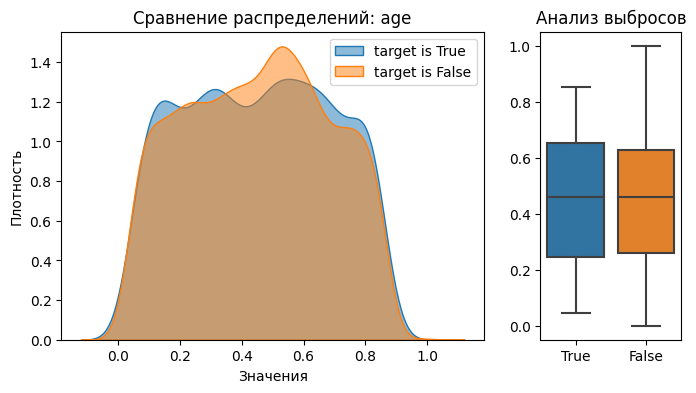

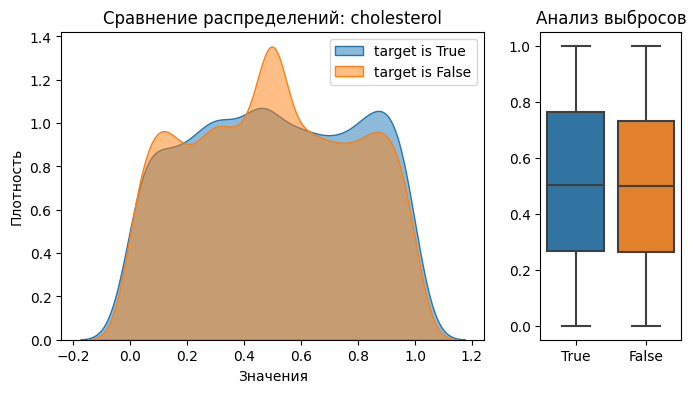

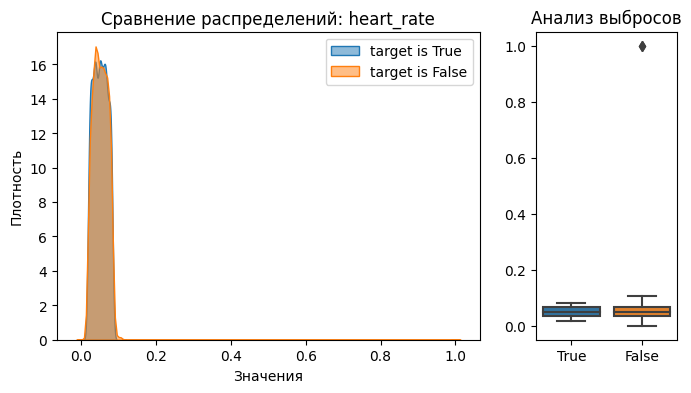

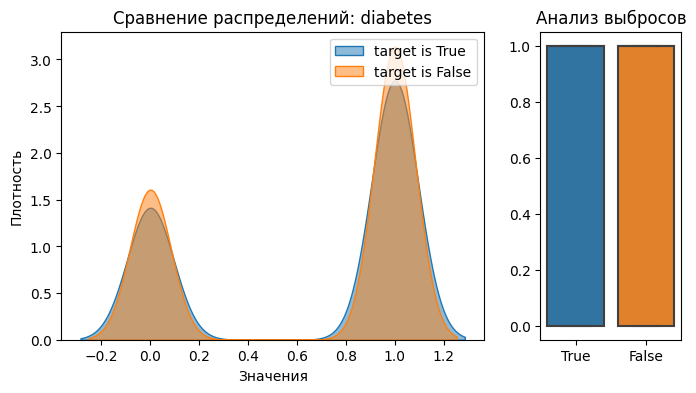

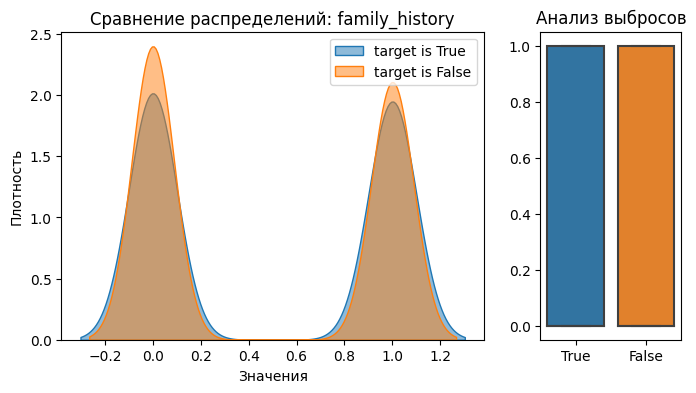

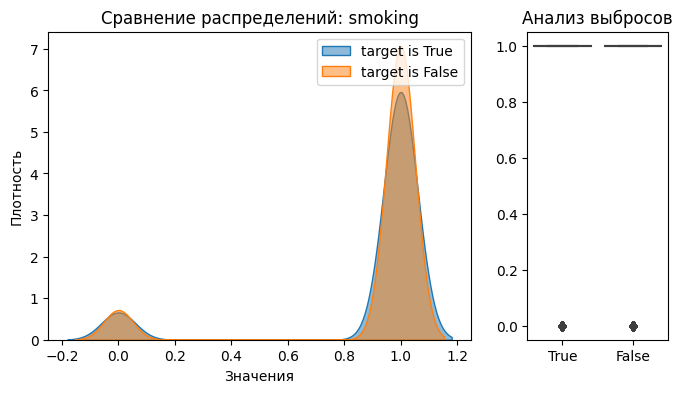

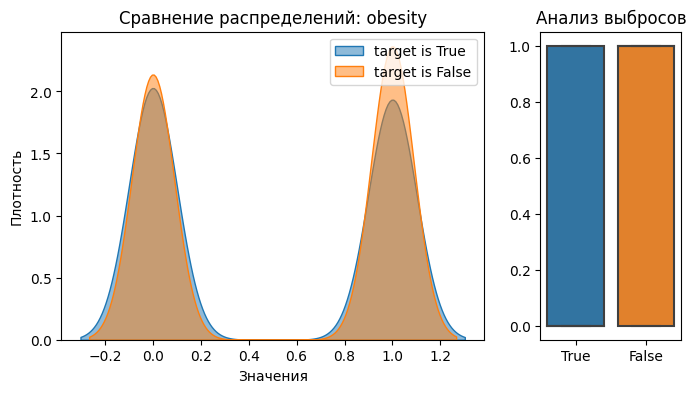

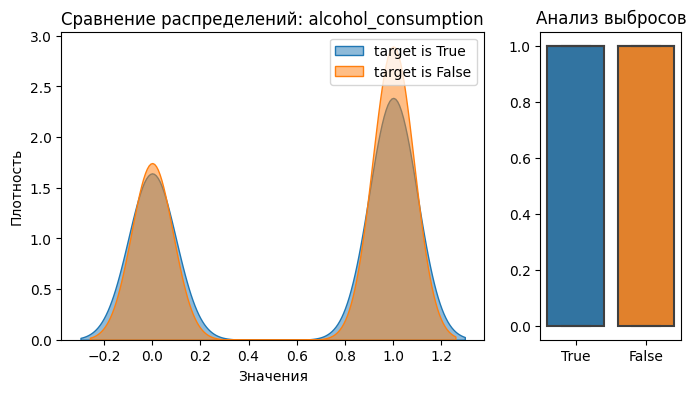

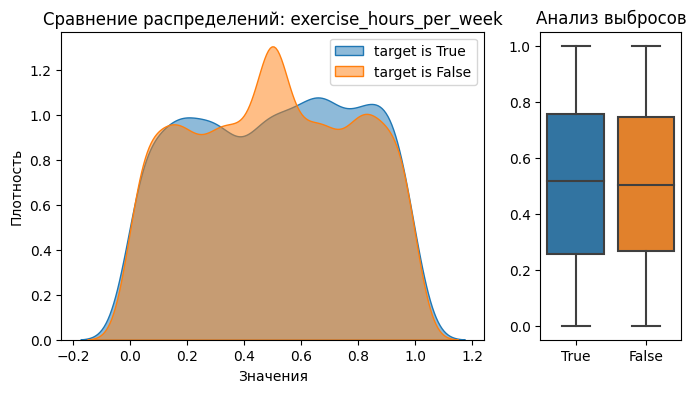

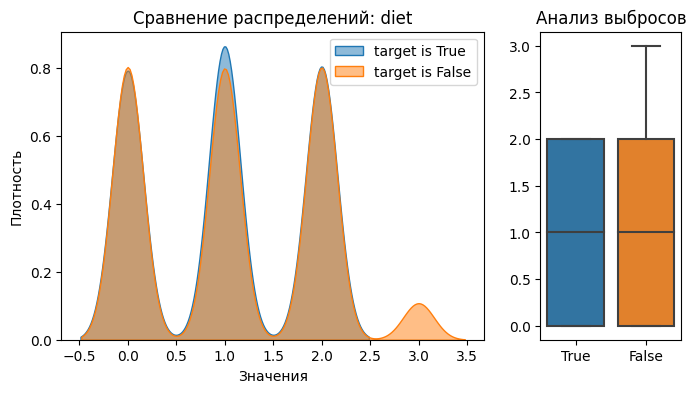

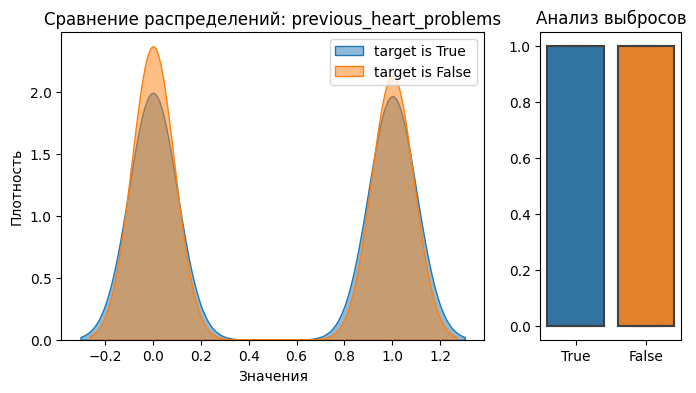

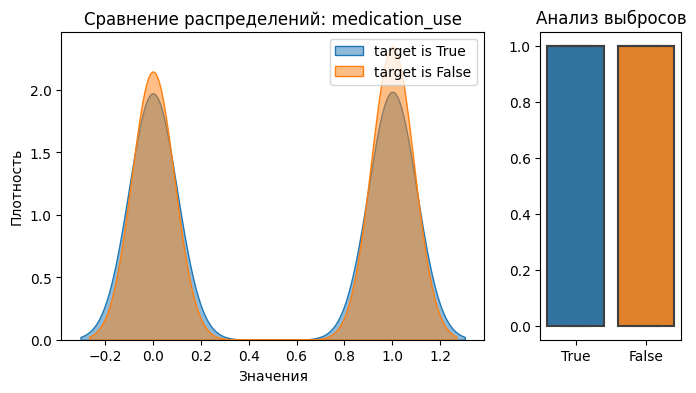

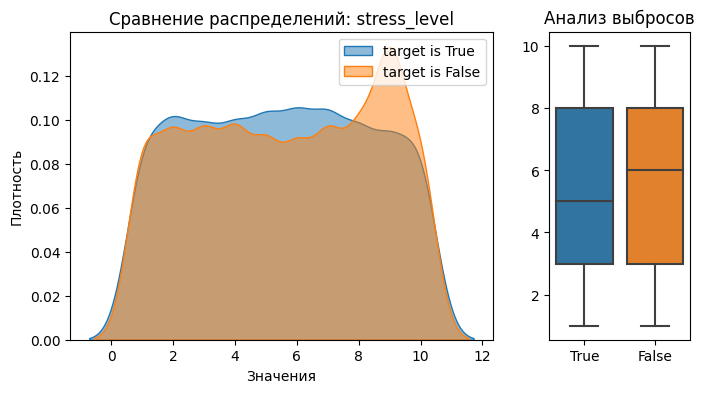

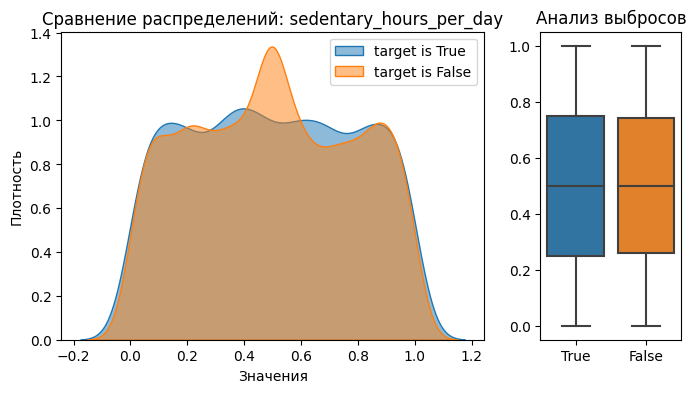

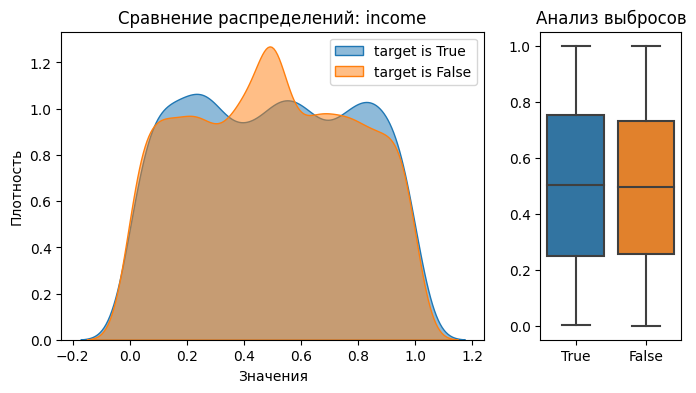

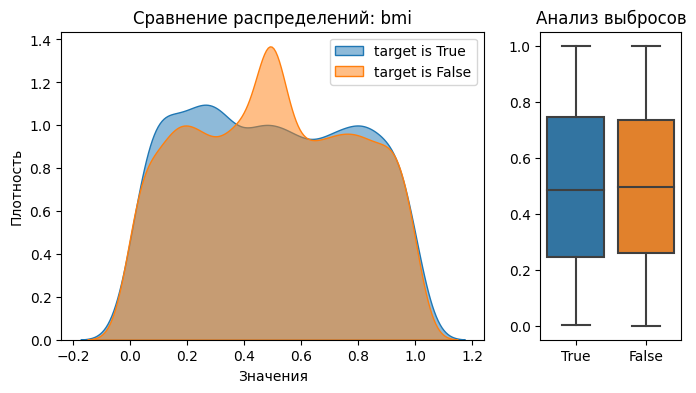

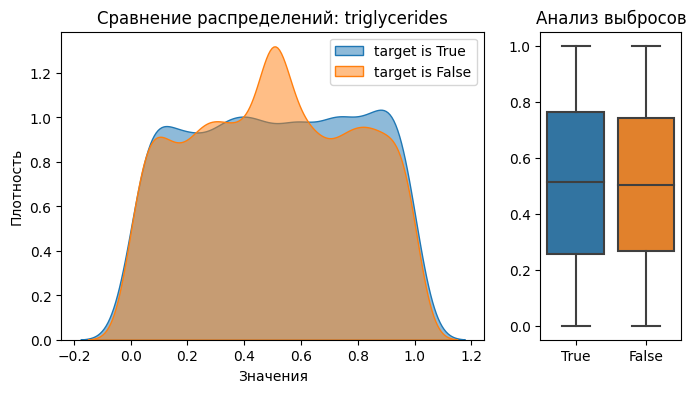

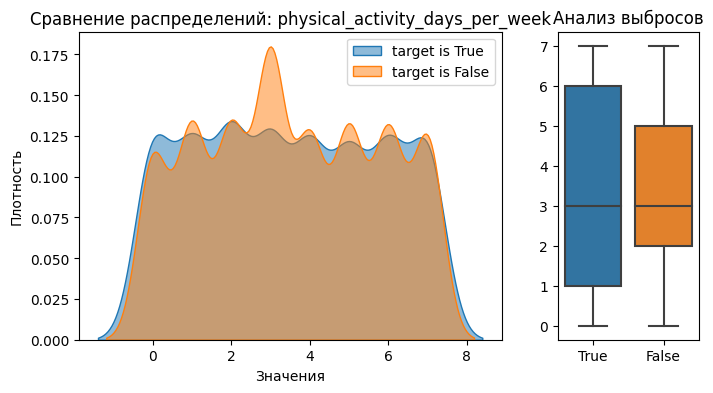

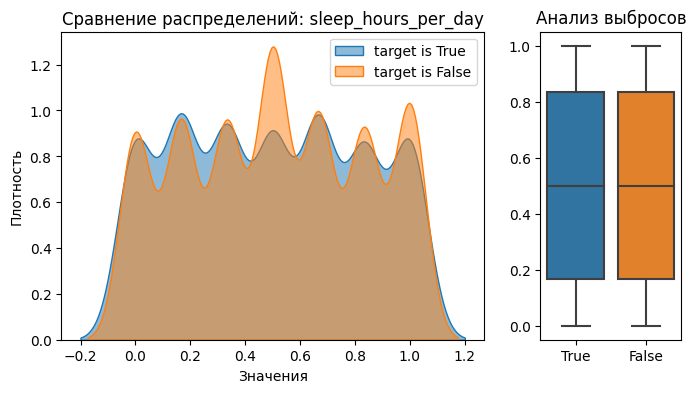

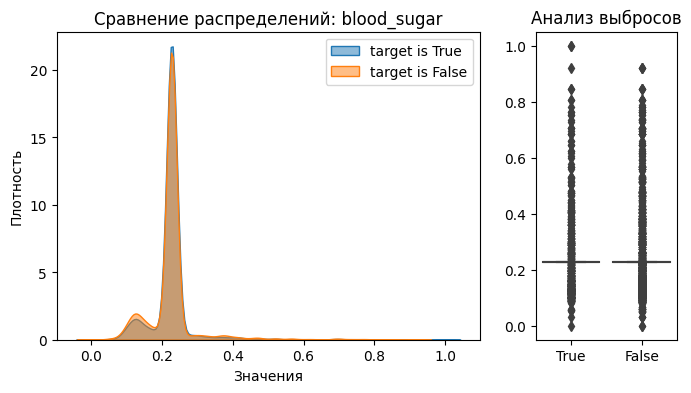

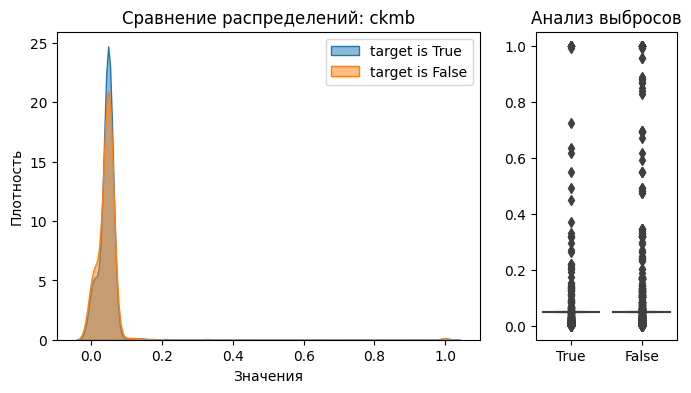

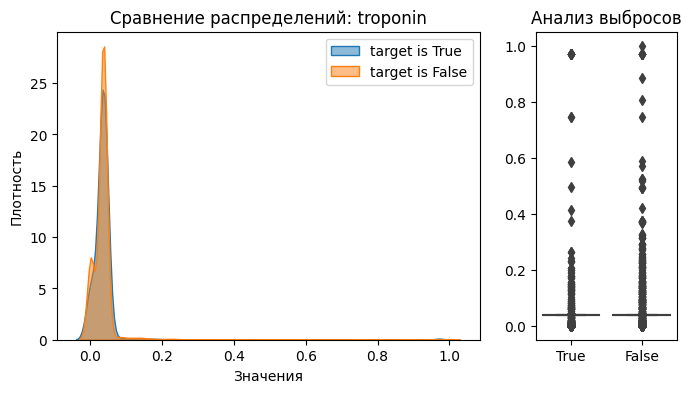

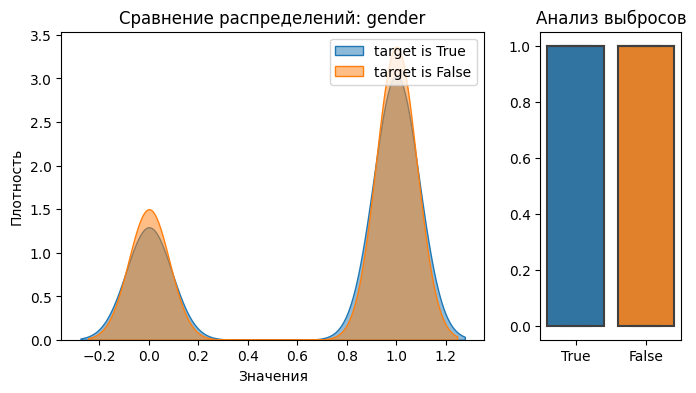

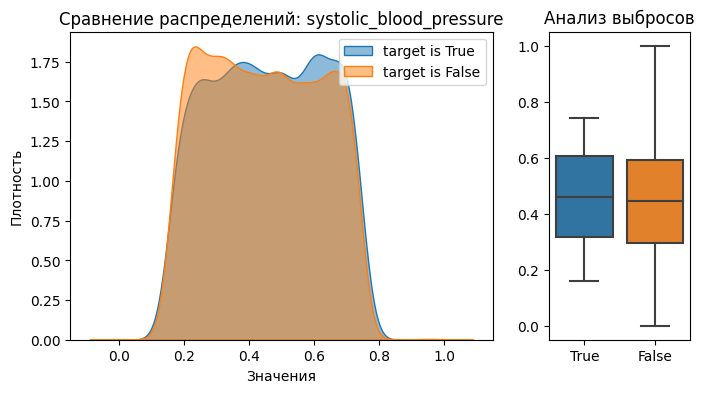

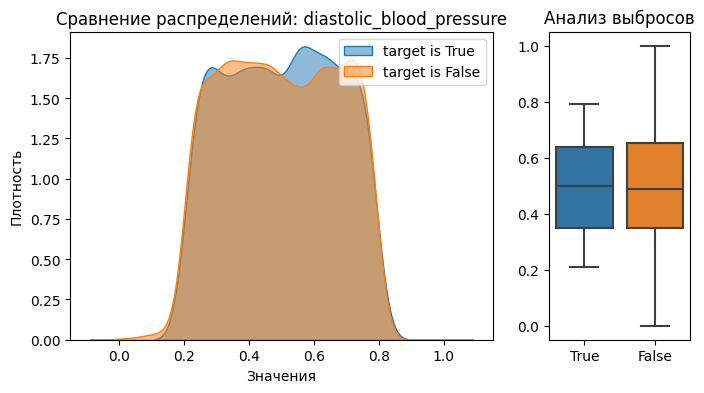

In [17]:
# отрисовка распределений и боксплотов признаков
col_num = train_data.select_dtypes(include=['number']).columns.tolist()
col_num = [col for col in col_num if col not in ["heart_attack_risk"]]

for col_i in col_num:
    complex_plot_cont(train_data, col_i)

Визуальный анализ позволяет сделать вывод о том, что характер распределений и форма распределений признаков практически идентичны не зависимо от значения таргета. Выявлено значительное число выбросов для признаков 'blood_sugar', 'ckmb', 'troponin'. Также обнаружены единичные выбросы для признака 'smoking'. В целом практически для всех признаков свойственно мультимодальное не нормальное распределенение.

In [18]:
# проведем анализ уникальных значений признаков 'blood_sugar', 'ckmb', 'troponin'
features_check = ['blood_sugar', 'ckmb', 'troponin']
for col in features_check:
    print(train_data[col].value_counts(normalize=True).head(3))
    print(f"дисперсия = {train_data[col].std():.4f}")
    print() 

0.227018    0.754289
0.128458    0.006448
0.102767    0.006333
Name: blood_sugar, dtype: float64
дисперсия = 0.0766

0.048229    0.754289
1.000000    0.003454
0.006237    0.001957
Name: ckmb, dtype: float64
дисперсия = 0.0755

0.036512    0.754289
0.000194    0.034773
0.000485    0.012550
Name: troponin, dtype: float64
дисперсия = 0.0602



Анализ уникальных значений признаков 'blood_sugar', 'ckmb', 'troponin' выявил то, что данные по всей видимости были округлены в результате чего 75% значений не имеют вариации.

In [19]:
# проанализируем значения признака 'heart_rate' где выявлены единичные выбросы
train_data['heart_rate'].sort_values(ascending=False).head(5)

id
9547    1.000000
9611    1.000000
9600    0.105408
9380    0.105408
9540    0.105408
Name: heart_rate, dtype: float64

Выявлено 2 анормальных значения, данные наблюдения буду исключены из датасета.

In [20]:
train_data = train_data.loc[~(train_data['heart_rate']==1)]

#### Вывод

 * Часть признаков в датасетах были заранее масштабированы. Имеется 11 закодированных категориальных признака.
 * Средние значения и вариация признаков в разрезе таргета совпадают. Для выявления различий между выборками в зависимости от значения таргета был использован тест Манна-Уитни по результатам которого выявлено 11 признаков которые имеют различия в зависимости от значения таргета.
 * Визуальный анализ распределений признаков в зависимости от значения таргета выявил, что характер распределений и форма распределений признаков практически идентичны не зависимо от значения таргета. Выявлено значительное число выбросов для признаков 'blood_sugar', 'ckmb', 'troponin'. Также обнаружены единичные выбросы для признака 'smoking'. В целом практически для всех признаков свойственно мультимодальное не нормальное распределенение.
 * Анализ уникальных значений признаков 'blood_sugar', 'ckmb', 'troponin' выявил то, что данные по всей видимости были округлены в результате чего 75% значений не имеют вариации.
 * Выявлено 2 анормальных значения, данные наблюдения буду исключены из датасета.

### Корреляционный анализ

Тренировочная выборка:



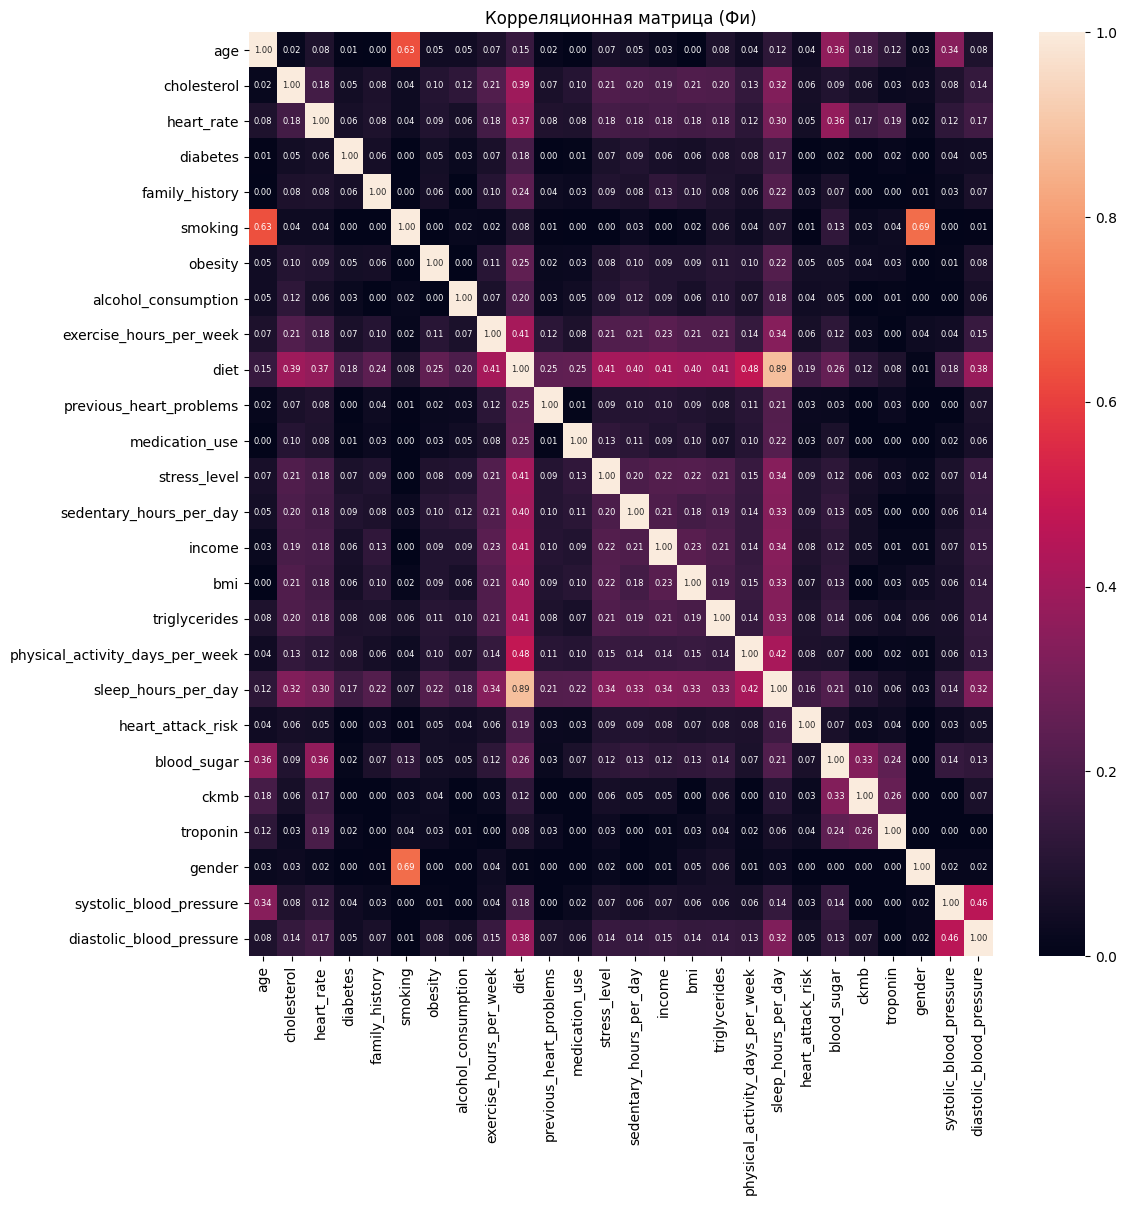

In [21]:
# разделим общий датасет на тренировочную и тестовую выборки
train_df = train_data.copy()
col_num = list(set(train_df.columns) - set(cat_col))
# рассчитаем корреляции признаков
print('Тренировочная выборка:\n')
cor_matrix = train_df.phik_matrix(interval_cols=col_num)
corr_df = pd.DataFrame(cor_matrix,
                       index = train_df.columns, 
                       columns=train_df.columns)
ax, fig = plt.subplots(figsize=(12, 12))
ax=sns.heatmap(corr_df, annot=True, annot_kws={"size": 6}, fmt='.2f')
ax.set_title('Корреляционная матрица (Фи)')
plt.show()

#### Вывод

 * Среди признаков отсутствует мультиколинеарность.
 * Не выявлена линейная зависимость таргета от признаков, отсюда использование логистической регрессии - нецелесообразно.

### Анализ признаков с точки зрения их природы

Рассмотрим показатели через призму современных стандартов и рекомендаций ВОЗ и доступных кардиологических исследований ([статья в Википедия](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%B0%D1%80%D0%BA%D1%82_%D0%BC%D0%B8%D0%BE%D0%BA%D0%B0%D1%80%D0%B4%D0%B0#%D0%A4%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D1%8B_%D1%80%D0%B8%D1%81%D0%BA%D0%B0)).
Часть показателей в силу своей природы могут дублировать друг друга, а также содержать утечку целевого признака.

|#| Название признака| Описание признака |
|:--:|:-------------|:-------------|
|1|'age'|возраст|
|2|'cholesterol'|холестерин|
|3|'heart_rate'|частота сердечных сокращений (пульс)|
|4|'diabetes'|наличие диабета|
|5|'family_history'|семейный анамнез (наличие проблем у родственников)|
|6|'smoking'|статус курения|
|7|'obesity'|ожирение|
|8|'alcohol_consumption'|употребление алкоголя|
|9|'exercise_hours_per_week'|количество часов физической активности в неделю|
|10|'diet'|режим питания (диета)|
|11|'previous_heart_problems'|история сердечных заболеваний|
|12|'medication_use'|использование лекарств, связанных с сердцем или другими заболеваниями|
|13|'stress_level'|уровень стресса|
|14|'sedentary_hours_per_day'|время, проведенное в малоподвижном состоянии|
|15|'income'|уровень дохода|
|16|'bmi'|индекс массы тела (ИМТ)|
|17|'triglycerides'|уровень триглицеридов в крови|
|18|'physical_activity_days_per_week'|количество дней физической активности в неделю|
|19|'sleep_hours_per_day'|среднее количество часов сна в сутки|
|20|**'heart_attack_risk'**|**риск сердечного приступа (таргет)**|
|21|'blood_sugar'|уровень сахара в крови|
|22|'ckmb'|Креатинкиназа-МВ (биомаркер повреждения сердечной мышцы)|
|23|'troponin'|тропонин (биомаркер сердечного повреждения)|
|24|'gender'|пол|
|25|'systolic_blood_pressure'|систолическое артериальное давление (верхнее значение давления)|
|26|'diastolic_blood_pressure'|диастолическое артериальное давление (нижнее значение давления)|

#### Вывод

 * 'sedentary_hours_per_day' и 'physical_activity_days_per_week' и 'exercise_hours_per_week' — первый отражает малоподвижность, второй и третий — активность. Эти признаки противоположны по смыслу и могут быть дубликатами.
 * 'bmi' и 'obesity' — оба показателя связаны с массой тела.
 * 'cholesterol' и 'triglycerides' — разные биохимические показатели и относятся к липидному обмену, не являются дублями, но могут быть скоррелированы.
 * 'previous_heart_problems', 'medication_use' и 'heart_attack_risk' — первые два признака отражают наличие ранее выявленных проблем с сердцем. Эти показатели связаны между собой по смыслу. В признаках 'previous_heart_problems' и 'medication_use' возможно наличие утечки целевого признака;
 * 'income' - не информативный признак;
 * 'diet' - не информативный признак.

### Общий вывод

 Необходимо исключить потенциальные дубликаты с точки зрения природы показателей, в качестве критерия будем учитывать результаты теста Манна-Уитни:
  * 'sedentary_hours_per_day' и 'physical_activity_days_per_week' и 'exercise_hours_per_week' --> оставляем 'exercise_hours_per_week';
  * 'bmi' и 'obesity' --> оставляет 'obesity';
  * 'previous_heart_problems', 'medication_use' --> удаляем оба как потенциальные протечки таргета;
  * 'blood_sugar', 'ckmb', 'troponin' --> удаляем все так как не информативные (в результате округления);
  * 'income', 'diet' --> исключим оба как не информативные.

In [22]:
exclude_list = ['sedentary_hours_per_day', 'physical_activity_days_per_week',
                'bmi', 'medication_use', 'previous_heart_problems', 'diet', 'income',
                 'exercise_hours_per_week', 'ckmb', 'troponin', 'blood_sugar']
train_data = train_data.drop(exclude_list, axis=1)
test_data = test_data.drop(exclude_list, axis=1)

## Поиск лучшей модели

### Подготовка и обработка данных

Таргет - бинарное значение, отсюда необходимо решать задачу бинарной классификации. В качестве возможных моделей будем рассматривать:
 * DecisionTree;
 * KNN;
 * SVC.
 
Линейная регрессия была исключена из перечня моделей, так как не выявлена линейная зависимость таргета от признаков. Для целей оптимизации решения будем использовать случайный поиск при помощи инструмента 'RandomizedSearchCV'

In [23]:
RANDOM_STATE = 27

# данные для моделирования
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(['heart_attack_risk'], axis=1),
    train_data.copy()['heart_attack_risk'],
    test_size = 0.25,
    random_state = RANDOM_STATE,
    stratify = train_data['heart_attack_risk']
)

# списки с названиями признаков
ohe_columns =[
    'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',   
    'stress_level', 'sleep_hours_per_day', 'gender'
]

num_columns = [
    'age', 'cholesterol', 'heart_rate', 'triglycerides', 
    'systolic_blood_pressure', 'diastolic_blood_pressure'
]

In [25]:
# создаем пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('num', MinMaxScaler())
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# создаем итоговый пайплайн 
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Финальный пайплайн и перечень моделей

In [26]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [27]:
# создаем список словарей моделей и гиперпараметров для перебора
param_grid = [
    # словарь для KNN
    {
        'models': [KNeighborsClassifier()],
        'models__weights': ['uniform', 'distance'],
        'models__n_neighbors': range(3, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
       
    # словать для SVC
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__degree': range(1, 6),
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [28]:
grid = list(ParameterGrid(param_grid))
print(f"Всего комбинаций: {len(grid)}")

Всего комбинаций: 294


### Поиск лучшей модели

Ключевой задачей классификации риска инфаркта является минимизация ложно-отрицательных предсказаний (ошибка второго рода). Лучшим показателем в данном случае будет выступать Recall. А задача сводится к максимизации Recall.

In [29]:
# поиск лучшей комбинации "модель-гиперпараметр"
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_iter=50,
    cv=cv,
    scoring=['recall', 'roc_auc', 'f1', 'accuracy'],
    refit='recall',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
).fit(X_train, y_train)

In [30]:
result = pd.DataFrame(randomized_search.cv_results_)
result_sort = result[
    ['mean_fit_time', 'param_models', 'param_preprocessor__num', 'mean_test_recall', 'mean_test_roc_auc', 
     'mean_test_f1', 'mean_test_accuracy',  'rank_test_roc_auc', 'rank_test_recall']
].sort_values('rank_test_recall').reset_index(drop=True)

print('Рейтинг моделей по показателю Recall:')
display(result_sort.head(10))

Рейтинг моделей по показателю Recall:


,mean_fit_time,param_models,param_preprocessor__num,mean_test_recall,mean_test_roc_auc,mean_test_f1,mean_test_accuracy,rank_test_roc_auc,rank_test_recall
0,0.041060,KNeighborsClassifier(),passthrough,0.359292,0.571429,0.382840,0.598585,4,1
1,0.050861,KNeighborsClassifier(),MinMaxScaler(),0.353540,0.572841,0.379022,0.598738,3,2
2,0.052550,KNeighborsClassifier(),StandardScaler(),0.343805,0.580259,0.376134,0.604422,1,3
3,10.351588,"SVC(probability=True, random_state=27)",passthrough,0.321681,0.495638,0.330089,0.546685,50,4
4,0.038792,KNeighborsClassifier(),passthrough,0.306195,0.580141,0.351760,0.608874,2,5
5,0.059033,KNeighborsClassifier(),MinMaxScaler(),0.175664,0.543096,0.244894,0.625154,10,6
6,0.041460,KNeighborsClassifier(),passthrough,0.172124,0.543419,0.241386,0.625153,9,7
7,15.544275,"SVC(probability=True, random_state=27)",passthrough,0.128761,0.536742,0.192102,0.626074,17,8
8,0.063268,DecisionTreeClassifier(random_state=27),StandardScaler(),0.100000,0.534955,0.154486,0.626840,19,9
9,0.055818,DecisionTreeClassifier(random_state=27),MinMaxScaler(),0.096460,0.544302,0.151429,0.627303,8,10


In [31]:
# лучшая модель
best_estimator = randomized_search.best_estimator_
print('Гиперпараметры лучшей модели:\n')
print(best_estimator)
best_model_class = best_estimator['models']
final_preprocessor = best_estimator['preprocessor']
X_test_transformed = final_preprocessor.transform(X_test)
y_pred = best_model_class.predict(X_test_transformed)

Гиперпараметры лучшей модели:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['diabetes', 'family_history',
                                                   'smoking', 'obesity',
                                                   'alcohol_consumption',
                                                   'stress_level',
                                                   '

### Метрики качества

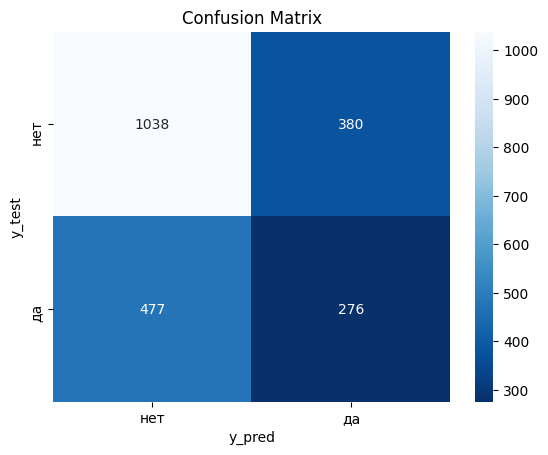


Метрики качества:
 Accuracy = 0.61
 Precision = 0.42
 Recall = 0.37
 ROC-AUC score: 0.59


In [32]:
# отрисовка графика
ax = plt.subplot()
lbls = ['нет', 'да']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues_r')
ax.set_xlabel('y_pred');
ax.set_ylabel('y_test'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lbls); 
ax.yaxis.set_ticklabels(lbls);
plt.show()
    
# расчет метрик качества
print('\nМетрики качества:')
print(f" Accuracy = {accuracy_score(y_test, y_pred):.2f}")
print(f" Precision = {(cm[1,1] / (cm[1,1] + cm[0,1])):.2f}")
print(f" Recall = {(cm[1,1] / (cm[1,1] + cm[1,0])):.2f}")
print(f" ROC-AUC score: {roc_auc_score(y_test, best_model_class.predict_proba(X_test_transformed)[:,1]):.2f}")

### Вывод

 * По результатам анализа лучший результат показала модель KNN. Сильной стороной KNN является выявление нелинейных зависимостей и устойчивость к выбросам.
 * Низкие предсказательные характеристики модели обусловлены особенностью входящих признаков, которые не имеют явных линейных связей с таргетом.
 * Для калибровки модели необходимо проанализировать влияние порога классификации на точность модели.

### Калибровка модели

In [33]:
# формула вывода прогноза скорректированной модели:
def predict_with_threshold(model, X_test_data, threshold=0.5):
    prob = model.predict_proba(X_test_data)[:, 1]
    out = pd.Series(prob).apply(lambda x: 1 if x > threshold else 0)
    return out

In [34]:
# функция для вывода показателей:
def model_metrics_def(y_true, y_scenario):
    cm = confusion_matrix(y_true, y_scenario)
    accuracy = accuracy_score(y_true, y_scenario)
    precision = precision_score(y_true, y_scenario, pos_label=1, zero_division=1)
    recall = recall_score(y_true, y_scenario, pos_label=1, zero_division=1)
    return (accuracy, precision, recall)

In [35]:
# функция вывода форматированной матрицы 
def confusion_matrix_def(y_test, y_pred, lbls=['нет', 'да']):
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues_r')
    # подписи осей:
    ax.set_xlabel('y_pred');
    ax.set_ylabel('y_test'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(lbls); 
    ax.yaxis.set_ticklabels(lbls);
    plt.show()

In [36]:
# выгрузка вероятностей исходной модели:
y_proba = best_model_class.predict_proba(X_test_transformed)[:, 1]

# подготовка данных:
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])

# создание диапазона вариации порога классификации:
thresholds = [round(i, 2) for i in np.arange(0.1, 1, 0.05)]

# заполнение таблицы прогнозов для различных значений порога классификации:
columns = []
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

# заполним таблицу с метриками:
summary_df = pd.DataFrame(thresholds)
np.zeros((data.shape[1]-2,3))

# заполним таблицу с метриками:
summary_df = pd.DataFrame(thresholds)
metr_matrix = np.zeros((data.shape[1]-2,3))
for i in range(data.shape[1]-2):
    for j in range(3):
        metr_matrix[i, j] = model_metrics_def(data['y_valid'], data.iloc[:, i+2])[j]
        
summary_df = pd.concat([summary_df, pd.DataFrame(metr_matrix)], axis=1)
summary_df.columns = ['thresholds', 'accuracy', 'precision', 'recall']
summary_df

,thresholds,accuracy,precision,recall
0,0.10,0.506679,0.388499,0.735724
1,0.15,0.508061,0.389318,0.735724
2,0.20,0.510364,0.389444,0.725100
3,0.25,0.524182,0.393130,0.683931
4,0.30,0.550898,0.404475,0.624170
5,0.35,0.585905,0.416667,0.484728
6,0.40,0.592354,0.414948,0.427623
7,0.45,0.598802,0.415714,0.386454
8,0.50,0.605251,0.420732,0.366534
9,0.55,0.608475,0.422151,0.349270


 Показатель recall достигает 0.7 при пороге классификации на уровне 0.2.

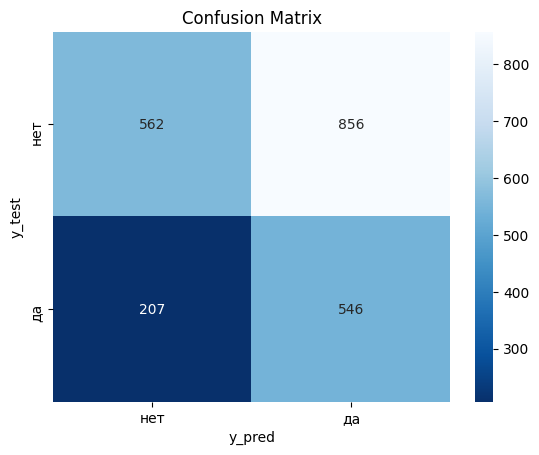


Метрики качества:
 Accuracy = 0.51
 Precision = 0.39
 Recall = 0.73
 ROC-AUC score: 0.59


In [37]:
y_pred = predict_with_threshold(best_model_class, X_test_transformed, threshold=0.2)

# отрисовка графика
ax = plt.subplot()
lbls = ['нет', 'да']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues_r')
ax.set_xlabel('y_pred');
ax.set_ylabel('y_test'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lbls); 
ax.yaxis.set_ticklabels(lbls);
plt.show()
    
# расчет метрик качества
print('\nМетрики качества:')
print(f" Accuracy = {accuracy_score(y_test, y_pred):.2f}")
print(f" Precision = {(cm[1,1] / (cm[1,1] + cm[0,1])):.2f}")
print(f" Recall = {(cm[1,1] / (cm[1,1] + cm[1,0])):.2f}")
print(f" ROC-AUC score: {roc_auc_score(y_test, best_model_class.predict_proba(X_test_transformed)[:,1]):.2f}")

## Экспорт / импорт объектов 

Для организации работы сервиса по предсказанию инфаркта необходимо был создан отдельный файл "classes.py" в котором хранятся класссы обьектов (трансформер, предпроцессор, модель с настроеным порогом классификации и класс вывода итоговой таблицы).

In [38]:
# импорт классов для последующего экспорта обьектов
from classes import DataTransformer, PreprocessorWrapper, ModelWithThreshold, PredictDataFrame

# определяем папку куда будут сохраняться объекты (создаем если она отсутствует)
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# создание экземпляра класса трансформера
data_transformer = DataTransformer()

# создание и экспорт экземпляра класса препроцессора
data_preprocessor = PreprocessorWrapper(final_preprocessor)
joblib.dump(data_preprocessor, os.path.join(save_dir, 'data_preprocessor.pkl'))

# создание и экспорт экземпляра класса модели с порогом классификации
model_with_threshold = ModelWithThreshold(best_model_class, threshold=0.2)
joblib.dump(model_with_threshold, os.path.join(save_dir, "model_with_threshold.pkl"))

# создание экземпляра класса для подготовки итоговой таблицы
final_data_prep = PredictDataFrame()

## Построение прогноза на тестовой выборке

In [39]:
# построение прогноза с использованием классов
X_test = pd.read_csv(os.path.join('data', 'heart_test.csv'))
X_test = data_transformer.transform(X_test)
X_test_transformed = data_preprocessor.transform(X_test)
predictions = model_with_threshold.predict(X_test_transformed)
final_df = final_data_prep.transform(df=X_test, pred=predictions)

# сохранение прогноза в формате csv
final_df.to_csv("test_data_predict.csv")

# вывод прогноза
print(final_df)

       id  prediction
0    7746           1
1    4202           1
2    6632           1
3    4639           0
4    4825           1
..    ...         ...
918  9271           1
919  8012           1
920  2456           1
921  4984           0
922  6521           1

[923 rows x 2 columns]


## Вывод

В рамках проекта проведена работа по анализу медицинских данных из открытого источника для цели обучения модели классификации с целью построения прогноза сердечного приступа (инфаркта). 

Данные были успешно загружены, проведена предобработка, исследовательский анализ данных в результате чего были отобраны ключевые признаки.  

На обработанных данных проведена работа подбора модели и гиперпараметров. Лучший результат показала модель  k-ближайших соседей с параметром n_neighbors=3 и учетом весов соседей в зависимости от расстояния (weights='distance') (KNN с взвешиванием по расстоянию между наблюдениями).

Для минимизации ложно отрицательных предсказаний модели выполнен подбор порога классификации (максимизация Recall).

Полученная модель, трансформер, препроцессор и подготовка итоговой таблицы были "обернуты" в отдельные классы для целей использования во внешнем сервисе с использованием FastAPI.